# Predicting return from Gold:
## Importing and Preparing Data:
For this and subsequent exercises we will need closing price of several instruments for past 10 years . There are various paid (Reuters, Bloomberg) and free resources (IEX, Quandl, Yahoofinance, Google finance) that we can use to either extract and load data in csv or we can directly call their APIs. Since in this project I needed different type of asset classes (Equities, Commodities, Debt and precious metals)

In [2]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install yahoofinancials
from yahoofinancials import YahooFinancials

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Import tickers 
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

<IPython.core.display.Javascript object>

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [4]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

Once we have the list, we need to define what date range we need to import the data for. The period I have chosen is Jan 2010 till 1st Mar 2020. The reason I did not pull data prior to that is because the GFC in 2008-09 massively changed the economic and market landscapes. Relationships pririo to that peirod might be of less relevance now. We also dont want to feed very less data as the models might tend to overfit.

We create a date-range and write it to an empty dataframe named values where we would extract and past the values we pull from yahoofinancials.

In [5]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-09-30"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Once we have the date range in dataframe, we need to use ticker symbols to pull out data from the API. yahoofinancials returns the output in a JSON format. The following code loops over the the list of ticker symbols and extracts just the closing prices for all the historical dates and keeps them adding to the dataframe horizontally. Note I have used the merge function to mantain the sanctity of dates. Given these asset classes might have different regional and trading holidays, the date ranges are not bound to be the same. By merging, we will eventually have several NAs which we will frontfill later on.

In [6]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2804, 17)
Date                         0
Gold                       122
Silver                     122
Crude Oil                  121
S&P500                     100
Russel 2000 Index          100
10 Yr US T-Note futures    123
2 Yr US T-Note Futures     121
Platinum                   122
Copper                     122
Dollar Index               123
Volatility Index           100
Soybean                    147
MSCI EM ETF                100
Euro USD                   338
Euronext100                 59
Nasdaq                     100
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2799,2020-09-24,1868.300049,23.118000,40.310001,3246.590088,1451.819946,139.578003,110.426003,837.099976,2.9690,94.393997,28.510000,NaN,42.900002,1.167324,948.109985,10672.269531
2800,2020-09-25,1857.699951,23.017000,40.250000,3298.459961,1474.910034,139.641006,110.438004,841.099976,2.9730,94.681999,26.379999,NaN,42.939999,NaN,944.549988,10913.559570
2801,2020-09-28,1872.800049,23.528000,40.599998,3351.600098,1510.339966,139.625000,110.441002,881.900024,2.9895,94.302002,26.190001,NaN,43.419998,1.167883,965.710022,11117.530273
2802,2020-09-29,1894.300049,24.379999,39.290001,3335.469971,1504.729980,139.781006,110.445000,887.500000,2.9835,93.927002,26.270000,NaN,43.389999,1.174205,962.190002,11085.250000
2803,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [9]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

<IPython.core.display.Javascript object>

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2799,2020-09-24,1868.3,23.1,40.3,3246.6,1451.8,139.6,110.4,837.1,3.0,94.4,28.5,903.8,42.9,1.2,948.1,10672.3
2800,2020-09-25,1857.7,23.0,40.2,3298.5,1474.9,139.6,110.4,841.1,3.0,94.7,26.4,903.8,42.9,1.2,944.5,10913.6
2801,2020-09-28,1872.8,23.5,40.6,3351.6,1510.3,139.6,110.4,881.9,3.0,94.3,26.2,903.8,43.4,1.2,965.7,11117.5
2802,2020-09-29,1894.3,24.4,39.3,3335.5,1504.7,139.8,110.4,887.5,3.0,93.9,26.3,903.8,43.4,1.2,962.2,11085.2
2803,2020-09-30,1894.3,24.4,39.3,3335.5,1504.7,139.8,110.4,887.5,3.0,93.9,26.3,903.8,43.4,1.2,962.2,11085.2


In [10]:
values.to_csv("Class_Training Data_Values.csv")

In [11]:
from pandas import DataFrame

imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2804, 1)


<IPython.core.display.Javascript object>

(2804, 17)


<IPython.core.display.Javascript object>

(2804, 33)


<IPython.core.display.Javascript object>

(2804, 49)


<IPython.core.display.Javascript object>

(2804, 65)


<IPython.core.display.Javascript object>

(2804, 81)
(2804, 81)


<IPython.core.display.Javascript object>

(2804, 86)


<IPython.core.display.Javascript object>

(2804, 91)


<IPython.core.display.Javascript object>

(2804, 96)


<IPython.core.display.Javascript object>

(2804, 101)


Besides just the lagged returns, we also see how far the current Gold price is from its moving average for with different window. This is a very commonly used metric in technical analysis where moving averages offer supports and resistances for asset prices. We use a combination of simple and exponential moving averages. We then add these moving averages to the existing feature space.

In [12]:
#Calculating Moving averages for Gold
ma = DataFrame(values['Date'],columns=['Date'])
ma['Date']=pd.to_datetime(ma['Date'],format='%Y-%b-%d')
ma['15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
ma['30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
ma['60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
ma['90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
ma['180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
ma['90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
ma['180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
ma = ma.dropna(axis=0)
print(ma.shape)
ma.head()

<IPython.core.display.Javascript object>

(2625, 8)


,Date,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


In [13]:
#Merging Moving Average values to the feature space
print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=ma,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2804, 101)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(2804, 108)


Date                              0
Gold-T-1                          1
Silver-T-1                        1
Crude Oil-T-1                     1
S&P500-T-1                        1
Russel 2000 Index-T-1             1
10 Yr US T-Note futures-T-1       1
2 Yr US T-Note Futures-T-1        1
Platinum-T-1                      1
Copper-T-1                        1
Dollar Index-T-1                  1
Volatility Index-T-1              1
Soybean-T-1                       1
MSCI EM ETF-T-1                   1
Euro USD-T-1                      1
Euronext100-T-1                   1
Nasdaq-T-1                        1
Gold-T-3                          3
Silver-T-3                        3
Crude Oil-T-3                     3
S&P500-T-3                        3
Russel 2000 Index-T-3             3
10 Yr US T-Note futures-T-3       3
2 Yr US T-Note Futures-T-3        3
Platinum-T-3                      3
Copper-T-3                        3
Dollar Index-T-3                  3
Volatility Index-T-3        

This wall all about features. Now we need to create targets, i.e what we want to predict. Since we are predicting returns, we need to pick a horizon for which we need to predict returns. I have chosen 14-day and 22-day horizons because other smaller horizons tend to be very volatile and lack and predictive power. One can however, experiment with other horizons as well.



In [14]:
#Caluculating forward returns for Target
y = DataFrame(data=values['Date'])
print(y.shape)

y['T+14']=values["Gold"].pct_change(periods=-14)
y['T+22']=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2804, 1)
(2804, 3)


Date     0
T+14    14
T+22    22
dtype: int64

In [15]:
# Removing NAs
print(data.shape)
data = data[data['Gold-T-250'].notna()]
y = y[y['T+22'].notna()]
print(data.shape)
print(y.shape)

(2804, 108)
(2554, 108)
(2782, 3)


In [16]:
# Now we will merge the Target variables with the feature space to get a data whcih we can finally start modelling on.

from pandas import merge

#Adding Target Variables
data = merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2532, 110)


Date                            0
Gold-T-1                        0
Silver-T-1                      0
Crude Oil-T-1                   0
S&P500-T-1                      0
Russel 2000 Index-T-1           0
10 Yr US T-Note futures-T-1     0
2 Yr US T-Note Futures-T-1      0
Platinum-T-1                    0
Copper-T-1                      0
Dollar Index-T-1                0
Volatility Index-T-1            0
Soybean-T-1                     0
MSCI EM ETF-T-1                 0
Euro USD-T-1                    0
Euronext100-T-1                 0
Nasdaq-T-1                      0
Gold-T-3                        0
Silver-T-3                      0
Crude Oil-T-3                   0
S&P500-T-3                      0
Russel 2000 Index-T-3           0
10 Yr US T-Note futures-T-3     0
2 Yr US T-Note Futures-T-3      0
Platinum-T-3                    0
Copper-T-3                      0
Dollar Index-T-3                0
Volatility Index-T-3            0
Soybean-T-3                     0
MSCI EM ETF-T-

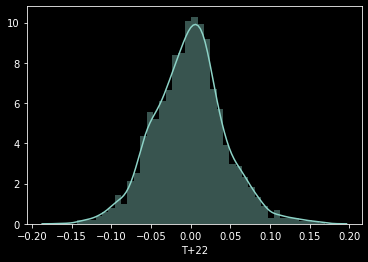

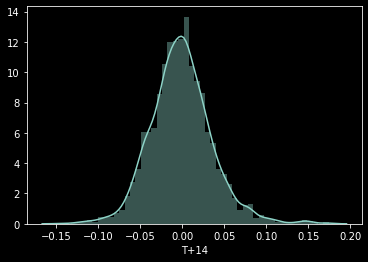

In [17]:
import seaborn as sns
plt.style.use('dark_background')
sns.distplot(data['T+22']); plt.show()
sns.distplot(data['T+14']); plt.show()

In [96]:
data.to_csv("Class_Training Data.csv",index=False)

## Creating Labels
We will try to predict any adverse (negative) return in Gold beyond a threshold.This threshold can be defined based on the risk tolerance of the investor. Here, I have taken the threshold to be 15% lowest return observations in the data history. In effect I am training to the model to predict a fall equal to or worse than 394 worse days in past 10 years.

In [97]:
import scipy.stats as st
#Select Threshold p (left tail probability)
p= 0.15
#Get z-Value
z = st.norm.ppf(p)
print(z)

-1.0364333894937898


In [98]:
#Calculating Threshold (t) for each Y
t_14 = round((z*np.std(data["T+14"]))+np.mean(data["T+14"]),5)
t_22 = round((z*np.std(data["T+22"]))+np.mean(data["T+22"]),5)

print("t_14=",t_14)
print("t_22=",t_22)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

t_14= -0.03922
t_22= -0.04839


So We can see above that threshold for 14-day model is -0.037 or -3.7%. This means that Gold returns over 140day period has been lower than -3.7% only 15 out of 100 days. We will label them as Target outcomes. Similar for T+22 days and T+5 Days

In [99]:
#Creating Labels
data['Y-14'] = (data['T+14']< t_14)*1
data['Y-22']= (data['T+22']< t_22)*1
print("Y-14", sum(data['Y-14']))
print("Y-22", sum(data['Y-22']))

Y-14 349
Y-22 380


In [100]:
data.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,T+14,T+22,Y-14,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250,0.007675,0,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422,0.011166,0,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.010555,0.030969,0,0
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.002023,0.034154,0,0
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,-0.004113,0.026404,0,0


In [101]:
# Now that we have the labels to predict, we can delet the return columns

data = data.drop(['T+14','T+22'],axis=1)
data.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,Y-14,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.097983,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0,0
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.097701,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0,0
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.104046,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0,0


# 22-Day Model

In [26]:
!pip install pycaret
from pycaret.classification import *

In [102]:
data_22 = data.drop(['Y-14'],axis=1)
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,15SMA,30SMA,60SMA,90SMA,180SMA,90EMA,180EMA,Y-22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.092754,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.086957,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.097983,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.097701,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.104046,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0


In [103]:
s22 = setup(data=data_22, target='Y-22', session_id=11, silent=True);

Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2532, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


INFO:logs:create_model_container 0
INFO:logs:master_model_container 0
INFO:logs:display_container 0
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      ml_usecase='regression',
                                      numerical_features=[], target='Y-22',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_i...
                ('group', Empty()), ('nonliner', Empty()), ('scaling', Empty()),
                ('P_transform', Empty()), ('pt_target', Empty()),
                ('binn', Empty()), ('rem_outliers', Empty()),
     

In [104]:
compare_models(turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.9289,0.9719,0.5983,0.8977,0.7145,0.6761,0.6962,2.8144
1,Extreme Gradient Boosting,0.9255,0.9653,0.5746,0.8925,0.6966,0.6566,0.6786,3.6145
2,Extra Trees Classifier,0.9238,0.9657,0.5456,0.9132,0.6794,0.6397,0.6690,0.4674
3,CatBoost Classifier,0.9187,0.9678,0.5154,0.9075,0.6504,0.6092,0.6438,30.4608
4,MLP Classifier,0.9170,0.9466,0.6353,0.7759,0.6941,0.6471,0.6540,27.9651
5,Gradient Boosting Classifier,0.9058,0.9368,0.4446,0.8603,0.5790,0.5334,0.5734,6.8063
6,Random Forest Classifier,0.8973,0.8913,0.3721,0.8629,0.5172,0.4706,0.5239,0.0941
7,Quadratic Discriminant Analysis,0.8854,0.8925,0.3195,0.8225,0.4410,0.3937,0.4565,0.0626
8,Ada Boost Classifier,0.8849,0.8671,0.3916,0.7102,0.5021,0.4438,0.4702,1.5455
9,Decision Tree Classifier,0.8826,0.7579,0.5796,0.6229,0.5968,0.5286,0.5313,0.3502


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=11, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=11, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [105]:
mlp = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9438,0.9850,0.7407,0.8696,0.8000,0.7676,0.7709
1,0.8989,0.9392,0.6667,0.6667,0.6667,0.6071,0.6071
2,0.8983,0.9447,0.5385,0.7000,0.6087,0.5514,0.5577
3,0.9435,0.9814,0.8077,0.8077,0.8077,0.7746,0.7746
4,0.9153,0.9218,0.6154,0.7619,0.6809,0.6326,0.6374
5,0.8814,0.8762,0.5769,0.6000,0.5882,0.5190,0.5191
6,0.9379,0.9726,0.7037,0.8636,0.7755,0.7399,0.7451
7,0.8983,0.9363,0.5185,0.7368,0.6087,0.5523,0.5635
8,0.8983,0.9316,0.4444,0.8000,0.5714,0.5190,0.5480
9,0.9548,0.9773,0.7407,0.9524,0.8333,0.8077,0.8162


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=11, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [106]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9438,0.9899,0.6667,0.9474,0.7826,0.7515,0.7668
1,0.9213,0.9752,0.5926,0.8421,0.6957,0.6521,0.6653
2,0.9322,0.9738,0.5769,0.9375,0.7143,0.6783,0.7041
3,0.9492,0.9829,0.7692,0.8696,0.8163,0.7869,0.7889
4,0.9322,0.9623,0.6154,0.8889,0.7273,0.6900,0.7052
5,0.9096,0.9470,0.5769,0.7500,0.6522,0.6012,0.6081
6,0.9322,0.9909,0.5926,0.9412,0.7273,0.6908,0.7150
7,0.9209,0.9442,0.5185,0.9333,0.6667,0.6259,0.6608
8,0.9096,0.9578,0.4815,0.8667,0.6190,0.5725,0.6044
9,0.9379,0.9946,0.5926,1.0000,0.7442,0.7114,0.7430


INFO:logs:create_model_container: 3
INFO:logs:master_model_container: 3
INFO:logs:display_container: 4
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=11, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [107]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9438,0.9772,0.6667,0.9474,0.7826,0.7515,0.7668
1,0.9101,0.9658,0.4815,0.8667,0.6190,0.5728,0.6046
2,0.9153,0.9664,0.4615,0.9231,0.6154,0.5736,0.6173
3,0.9435,0.9861,0.6923,0.9000,0.7826,0.7508,0.7593
4,0.9435,0.9513,0.6538,0.9444,0.7727,0.7417,0.7580
5,0.9040,0.9363,0.5000,0.7647,0.6047,0.5527,0.5689
6,0.9266,0.9868,0.5185,1.0000,0.6829,0.6461,0.6908
7,0.9040,0.9369,0.4444,0.8571,0.5854,0.5371,0.5743
8,0.9153,0.9560,0.4815,0.9286,0.6341,0.5916,0.6325
9,0.9322,0.9942,0.5556,1.0000,0.7143,0.6793,0.7172


INFO:logs:create_model_container: 4
INFO:logs:master_model_container: 4
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=11, verbose=0,
                     warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [108]:
catb = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9438,0.9826,0.6667,0.9474,0.7826,0.7515,0.7668
1,0.9101,0.9735,0.4444,0.9231,0.6000,0.5562,0.6036
2,0.9096,0.9679,0.4615,0.8571,0.6000,0.5542,0.5880
3,0.9322,0.9817,0.6154,0.8889,0.7273,0.6900,0.7052
4,0.9266,0.9745,0.5769,0.8824,0.6977,0.6579,0.6772
5,0.8983,0.9483,0.5000,0.7222,0.5909,0.5350,0.5468
6,0.9379,0.9874,0.6296,0.9444,0.7556,0.7216,0.7411
7,0.8983,0.9123,0.3704,0.9091,0.5263,0.4804,0.5417
8,0.9040,0.9563,0.3704,1.0000,0.5405,0.4993,0.5768
9,0.9266,0.9938,0.5185,1.0000,0.6829,0.6461,0.6908


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 6
INFO:logs:<catboost.core.CatBoostClassifier object at 0x00000282EFC9B8B0>
INFO:logs:create_model() succesfully completed......................................


### Hyparameters tunning:

In [109]:
mlp_tune = tune_model(mlp, n_iter=50,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9607,0.9872,0.8519,0.8846,0.8679,0.8448,0.8450
1,0.9045,0.9367,0.6296,0.7083,0.6667,0.6112,0.6126
2,0.8870,0.9297,0.5385,0.6364,0.5833,0.5185,0.5209
3,0.9096,0.9501,0.6923,0.6923,0.6923,0.6393,0.6393
4,0.8870,0.8963,0.5769,0.6250,0.6000,0.5343,0.5349
5,0.8644,0.8510,0.6154,0.5333,0.5714,0.4914,0.4932
6,0.9153,0.9667,0.6667,0.7500,0.7059,0.6566,0.6581
7,0.9096,0.9227,0.6296,0.7391,0.6800,0.6278,0.6305
8,0.8870,0.9146,0.4444,0.7059,0.5455,0.4847,0.5017
9,0.9492,0.9514,0.7037,0.9500,0.8085,0.7799,0.7916


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 7
INFO:logs:MLPClassifier(activation='relu', alpha=0.0884, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 100), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=11, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [110]:
lgbm_tune = tune_model(lgbm, n_iter=50,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8989,0.9419,0.5185,0.7368,0.6087,0.5526,0.5639
1,0.8820,0.8931,0.4074,0.6875,0.5116,0.4495,0.4694
2,0.8814,0.8800,0.3846,0.6667,0.4878,0.4261,0.4468
3,0.8870,0.9170,0.5385,0.6364,0.5833,0.5185,0.5209
4,0.9096,0.9307,0.5769,0.7500,0.6522,0.6012,0.6081
5,0.9040,0.9249,0.5769,0.7143,0.6383,0.5836,0.5881
6,0.9379,0.9600,0.7037,0.8636,0.7755,0.7399,0.7451
7,0.8983,0.8531,0.4815,0.7647,0.5909,0.5362,0.5550
8,0.8870,0.8936,0.4444,0.7059,0.5455,0.4847,0.5017
9,0.9153,0.9525,0.5556,0.8333,0.6667,0.6203,0.6371


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 8
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.9, max_depth=100,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=70, n_jobs=-1, num_leaves=10, objective=None,
               random_state=11, reg_alpha=0.9, reg_lambda=0.3, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


In [111]:
et_tune = tune_model (et, n_iter=150)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8483,0.7871,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8483,0.7048,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8531,0.6637,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8531,0.8567,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8531,0.7272,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8531,0.7378,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8475,0.7275,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8475,0.6830,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8475,0.6443,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.8475,0.7390,0.0000,0.0000,0.0000,0.0000,0.0000


INFO:logs:create_model_container: 8
INFO:logs:master_model_container: 8
INFO:logs:display_container: 9
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=1, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=7,
                     min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=-1,
                     oob_score=False, random_state=11, verbose=0,
                     warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [112]:
catb_tune = tune_model(catb, n_iter=150,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9494,0.9880,0.7407,0.9091,0.8163,0.7874,0.7929
1,0.9101,0.9409,0.7037,0.7037,0.7037,0.6507,0.6507
2,0.9266,0.9648,0.5385,0.9333,0.6829,0.6447,0.6760
3,0.9718,0.9656,0.8846,0.9200,0.9020,0.8855,0.8857
4,0.9379,0.9536,0.6538,0.8947,0.7556,0.7209,0.7326
5,0.9040,0.9254,0.6154,0.6957,0.6531,0.5976,0.5991
6,0.9379,0.9862,0.7037,0.8636,0.7755,0.7399,0.7451
7,0.9096,0.9449,0.5185,0.8235,0.6364,0.5878,0.6083
8,0.8927,0.9306,0.4444,0.7500,0.5581,0.5016,0.5238
9,0.9322,0.9723,0.6296,0.8947,0.7391,0.7015,0.7158


INFO:logs:create_model_container: 9
INFO:logs:master_model_container: 9
INFO:logs:display_container: 10
INFO:logs:<catboost.core.CatBoostClassifier object at 0x00000282F01A5A30>
INFO:logs:tune_model() succesfully completed......................................


## Ensemble approach:
### Bagging & Boosting:
Bagging serves as a good introduction to ensemble methods because it is relatively
easy to understand and because it is relatively easy to demonstrate its variance
reduction properties.

In [113]:
mlp_bagged = ensemble_model(estimator=mlp, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9551,0.9853,0.7778,0.9130,0.8400,0.8141,0.8176
1,0.8933,0.9299,0.5185,0.7000,0.5957,0.5358,0.5438
2,0.9096,0.9465,0.4615,0.8571,0.6000,0.5542,0.5880
3,0.9492,0.9702,0.7308,0.9048,0.8085,0.7796,0.7855
4,0.8983,0.9187,0.5385,0.7000,0.6087,0.5514,0.5577
5,0.8701,0.8877,0.5000,0.5652,0.5306,0.4555,0.4567
6,0.9209,0.9570,0.5926,0.8421,0.6957,0.6518,0.6651
7,0.9096,0.9341,0.5556,0.7895,0.6522,0.6020,0.6143
8,0.8927,0.9328,0.3704,0.8333,0.5128,0.4624,0.5106
9,0.9266,0.9578,0.5556,0.9375,0.6977,0.6590,0.6882


INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
INFO:logs:display_container: 11
INFO:logs:BaggingClassifier(base_estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                               batch_size='auto', beta_1=0.9,
                                               beta_2=0.999,
                                               early_stopping=False,
                                               epsilon=1e-08,
                                               hidden_layer_sizes=(100,),
                                               learning_rate='constant',
                                               learning_rate_init=0.001,
                                               max_fun=15000, max_iter=500,
                                               momentum=0.9,
                                               n_iter_no_change=10,
                                               nesterovs_momentum=True,
                                     

In [114]:
et_boosting = ensemble_model(estimator=et, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9438,0.9893,0.6667,0.9474,0.7826,0.7515,0.7668
1,0.8933,0.9590,0.3704,0.8333,0.5128,0.4627,0.5109
2,0.9096,0.9710,0.5385,0.7778,0.6364,0.5867,0.5996
3,0.9435,0.9866,0.6923,0.9000,0.7826,0.7508,0.7593
4,0.9322,0.9525,0.5385,1.0000,0.7000,0.6656,0.7063
5,0.9096,0.9350,0.6154,0.7273,0.6667,0.6148,0.6177
6,0.9209,0.9860,0.5185,0.9333,0.6667,0.6259,0.6608
7,0.8927,0.9277,0.3704,0.8333,0.5128,0.4624,0.5106
8,0.8983,0.9481,0.4444,0.8000,0.5714,0.5190,0.5480
9,0.9322,0.9900,0.5556,1.0000,0.7143,0.6793,0.7172


INFO:logs:create_model_container: 11
INFO:logs:master_model_container: 11
INFO:logs:display_container: 12
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                      

In [115]:
catb_tune_boosted = ensemble_model(estimator=catb_tune, method= 'Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9382,0.9826,0.5926,1.0000,0.7442,0.7116,0.7432
1,0.8820,0.9539,0.4074,0.6875,0.5116,0.4495,0.4694
2,0.8927,0.9712,0.4231,0.7333,0.5366,0.4808,0.5041
3,0.9379,0.9697,0.6538,0.8947,0.7556,0.7209,0.7326
4,0.9153,0.9483,0.5000,0.8667,0.6341,0.5901,0.6187
5,0.8983,0.9376,0.5385,0.7000,0.6087,0.5514,0.5577
6,0.9153,0.9788,0.5926,0.8000,0.6809,0.6332,0.6427
7,0.8927,0.9578,0.3333,0.9000,0.4865,0.4403,0.5087
8,0.8927,0.9323,0.4074,0.7857,0.5366,0.4827,0.5161
9,0.9266,0.9723,0.5185,1.0000,0.6829,0.6461,0.6908


INFO:logs:create_model_container: 12
INFO:logs:master_model_container: 12
INFO:logs:display_container: 13
INFO:logs:BaggingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x00000282F01A5A30>,
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
                  random_state=11, verbose=0, warm_start=False)
INFO:logs:ensemble_model() succesfully completed......................................


In [116]:
lgbm_bagged = ensemble_model(lgbm, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9382,0.9904,0.6296,0.9444,0.7556,0.7218,0.7413
1,0.9157,0.9750,0.4815,0.9286,0.6341,0.5919,0.6328
2,0.9209,0.9727,0.4615,1.0000,0.6316,0.5939,0.6499
3,0.9379,0.9776,0.5769,1.0000,0.7317,0.6994,0.7333
4,0.9153,0.9605,0.4615,0.9231,0.6154,0.5736,0.6173
5,0.9096,0.9521,0.5000,0.8125,0.6190,0.5710,0.5927
6,0.9322,0.9844,0.5556,1.0000,0.7143,0.6793,0.7172
7,0.8927,0.9373,0.3704,0.8333,0.5128,0.4624,0.5106
8,0.9040,0.9378,0.3704,1.0000,0.5405,0.4993,0.5768
9,0.9209,0.9847,0.4815,1.0000,0.6500,0.6115,0.6636


INFO:logs:create_model_container: 13
INFO:logs:master_model_container: 13
INFO:logs:display_container: 14
INFO:logs:BaggingClassifier(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                class_weight=None,
                                                colsample_bytree=1.0,
                                                importance_type='split',
                                                learning_rate=0.1, max_depth=-1,
                                                min_child_samples=20,
                                                min_child_weight=0.001,
                                                min_split_gain=0.0,
                                                n_estimators=100, n_jobs=-1,
                                                num_leaves=31, objective=None,
                                                random_state=11, reg_alpha=0.0,
                                                reg_lambda=0.0, silent=True,


In [117]:
lgbm_boosted = ensemble_model(lgbm, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9438,0.9841,0.6667,0.9474,0.7826,0.7515,0.7668
1,0.9382,0.9777,0.6667,0.9000,0.7660,0.7313,0.7422
2,0.9096,0.9679,0.4615,0.8571,0.6000,0.5542,0.5880
3,0.9435,0.9819,0.7692,0.8333,0.8000,0.7672,0.7680
4,0.9153,0.9610,0.5769,0.7895,0.6667,0.6195,0.6295
5,0.9096,0.9491,0.5769,0.7500,0.6522,0.6012,0.6081
6,0.9379,0.9827,0.6296,0.9444,0.7556,0.7216,0.7411
7,0.9153,0.9227,0.5185,0.8750,0.6512,0.6065,0.6334
8,0.9153,0.9674,0.4815,0.9286,0.6341,0.5916,0.6325
9,0.9322,0.9914,0.5556,1.0000,0.7143,0.6793,0.7172


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 15
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                 class_weight=None,
                                                 colsample_bytree=1.0,
                                                 importance_type='split',
                                                 learning_rate=0.1,
                                                 max_depth=-1,
                                                 min_child_samples=20,
                                                 min_child_weight=0.001,
                                                 min_split_gain=0.0,
                                                 n_estimators=100, n_jobs=-1,
                                                 num_leaves=31, objective=None,
                                                 random_st

### Blending models:

In [118]:
blend1 = blend_models(estimator_list=[mlp,lgbm,et])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9494,0.0000,0.7037,0.9500,0.8085,0.7801,0.7918
1,0.9270,0.0000,0.5926,0.8889,0.7111,0.6712,0.6893
2,0.9379,0.0000,0.5769,1.0000,0.7317,0.6994,0.7333
3,0.9435,0.0000,0.7308,0.8636,0.7917,0.7592,0.7628
4,0.9266,0.0000,0.6154,0.8421,0.7111,0.6702,0.6810
5,0.9096,0.0000,0.5769,0.7500,0.6522,0.6012,0.6081
6,0.9435,0.0000,0.6296,1.0000,0.7727,0.7424,0.7683
7,0.9153,0.0000,0.5185,0.8750,0.6512,0.6065,0.6334
8,0.9096,0.0000,0.4444,0.9231,0.6000,0.5560,0.6034
9,0.9379,0.0000,0.5926,1.0000,0.7442,0.7114,0.7430


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 16
INFO:logs:VotingClassifier(estimators=[('MLP Classifier_0',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(100,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_s...
                                          

In [119]:
blend2 = blend_models(estimator_list=[lgbm,et], method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9551,0.9818,0.7407,0.9524,0.8333,0.8078,0.8164
1,0.9213,0.9723,0.5926,0.8421,0.6957,0.6521,0.6653
2,0.9209,0.9745,0.5385,0.8750,0.6667,0.6247,0.6484
3,0.9435,0.9893,0.6923,0.9000,0.7826,0.7508,0.7593
4,0.9379,0.9519,0.6154,0.9412,0.7442,0.7106,0.7314
5,0.9096,0.9384,0.5769,0.7500,0.6522,0.6012,0.6081
6,0.9322,0.9899,0.5926,0.9412,0.7273,0.6908,0.7150
7,0.9096,0.9410,0.4815,0.8667,0.6190,0.5725,0.6044
8,0.9096,0.9570,0.4444,0.9231,0.6000,0.5560,0.6034
9,0.9322,0.9943,0.5556,1.0000,0.7143,0.6793,0.7172


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 17
INFO:logs:VotingClassifier(estimators=[('Light Gradient Boosting Machine_0',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=11, reg_alpha=0.0,
                                           

## Stacking Models

In [78]:
#stack1 = create_stacknet(estimator_list=[[catb_tune,blend2],[mlp]], restack=False)

In [120]:
stack2 = stack_models(estimator_list=[catb_tune,blend2], meta_model=mlp, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9494,0.9836,0.8519,0.8214,0.8364,0.8065,0.8067
1,0.9157,0.9169,0.7778,0.7000,0.7368,0.6868,0.6882
2,0.9153,0.9412,0.5769,0.7895,0.6667,0.6195,0.6295
3,0.9661,0.9804,0.9231,0.8571,0.8889,0.8689,0.8698
4,0.9322,0.9363,0.7692,0.7692,0.7692,0.7295,0.7295
5,0.8870,0.9030,0.7308,0.5938,0.6552,0.5885,0.5930
6,0.9774,0.9948,0.9259,0.9259,0.9259,0.9126,0.9126
7,0.9209,0.9447,0.6296,0.8095,0.7083,0.6634,0.6704
8,0.9096,0.9247,0.5926,0.7619,0.6667,0.6153,0.6218
9,0.9492,0.9699,0.7407,0.9091,0.8163,0.7872,0.7927


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 18
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('CatBoostClassifier_0',
                                <catboost.core.CatBoostClassifier object at 0x00000282F01A5A30>),
                               ('VotingClassifier_1',
                                VotingClassifier(estimators=[('Light Gradient '
                                                              'Boosting '
                                                              'Machine_0',
                                                              LGBMClassifier(boosting_type='gbdt',
                                                                             class_weight=None,
                                                                             colsample_bytree=1.0,
                                                                             importance_type='split',
                         

In [121]:
stack3 = stack_models(estimator_list=[catb_tune,blend2], meta_model=mlp, restack=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9607,0.9909,0.8519,0.8846,0.8679,0.8448,0.8450
1,0.9213,0.9713,0.8148,0.7097,0.7586,0.7119,0.7143
2,0.9266,0.9773,0.6923,0.7826,0.7347,0.6923,0.6940
3,0.9718,0.9893,0.9615,0.8621,0.9091,0.8924,0.8943
4,0.9492,0.9501,0.8462,0.8148,0.8302,0.8003,0.8005
5,0.9096,0.9376,0.7692,0.6667,0.7143,0.6609,0.6633
6,0.9605,0.9904,0.8519,0.8846,0.8679,0.8447,0.8449
7,0.9153,0.9472,0.5926,0.8000,0.6809,0.6332,0.6427
8,0.9266,0.9612,0.7778,0.7500,0.7636,0.7202,0.7203
9,0.9605,0.9946,0.7778,0.9545,0.8571,0.8345,0.8404


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 19
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('CatBoostClassifier_0',
                                <catboost.core.CatBoostClassifier object at 0x00000282F01A5A30>),
                               ('VotingClassifier_1',
                                VotingClassifier(estimators=[('Light Gradient '
                                                              'Boosting '
                                                              'Machine_0',
                                                              LGBMClassifier(boosting_type='gbdt',
                                                                             class_weight=None,
                                                                             colsample_bytree=1.0,
                                                                             importance_type='split',
                         

In [77]:
#stack4 = create_stacknet(estimator_list=[[catb_tuned,blend2,mlp],[mlp]], restack=False)

## Evaluation

In [51]:
!pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [53]:
import scikitplot 

In [122]:
evaluate_model(mlp)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [55]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [56]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [57]:
a = predict_model(stack3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9636,0.9804,0.8692,0.8857,0.8774,0.856,0.856


In [58]:
print(a['Label'].sum())
print(a['Y-22'].sum())
print(a.shape)

105
107
(714, 131)


In [59]:
classifier_22 = finalize_model(stack3)
save_model(classifier_22,"22D Classifier")

Transformation Pipeline and Model Succesfully Saved


# 14- Day Model:

In [60]:
data_14 = data.drop(['Y-22'],axis=1)
s14 = setup(data=data_14, target='Y-14', session_id=11, silent=True, ignore_features=['Date']);

Setup Succesfully Completed!


,Description,Value
0,session_id,11
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [61]:
compare_models(sort='Recall', turbo= False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,MLP Classifier,0.9195,0.9354,0.6493,0.7618,0.6951,0.6494,0.6558,7.8179
1,K Neighbors Classifier,0.9165,0.9236,0.6333,0.7517,0.6831,0.6357,0.6413,0.0308
2,Decision Tree Classifier,0.8631,0.7161,0.5107,0.5200,0.5130,0.4337,0.4350,0.1793
3,Extreme Gradient Boosting,0.9117,0.9309,0.4899,0.8403,0.6106,0.5651,0.5954,0.5189
4,Light Gradient Boosting Machine,0.9135,0.9305,0.4801,0.8679,0.6050,0.5621,0.5999,0.4687
5,Naive Bayes,0.7298,0.6718,0.3967,0.2359,0.2948,0.1418,0.1493,0.0068
6,Extra Trees Classifier,0.9045,0.9487,0.3871,0.8676,0.5289,0.4856,0.5373,0.1790
7,CatBoost Classifier,0.8973,0.9363,0.3585,0.8437,0.4943,0.4480,0.5026,14.3821
8,Gradient Boosting Classifier,0.8925,0.8999,0.3413,0.7805,0.4664,0.4185,0.4659,4.0822
9,Linear Discriminant Analysis,0.8708,0.7756,0.3241,0.5718,0.4089,0.3444,0.3636,0.0347


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=11, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [62]:
mlp14 = create_model('mlp')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.9417,0.5833,0.8235,0.6829,0.6400,0.6524
1,0.9162,0.9499,0.5833,0.7778,0.6667,0.6198,0.6282
2,0.9341,0.9610,0.8333,0.7407,0.7843,0.7456,0.7474
3,0.9222,0.9601,0.7083,0.7391,0.7234,0.6781,0.6783
4,0.9042,0.9580,0.5417,0.7222,0.6190,0.5655,0.5732
5,0.9398,0.9751,0.6522,0.8824,0.7500,0.7166,0.7272
6,0.9096,0.9313,0.6522,0.6818,0.6667,0.6144,0.6146
7,0.8976,0.8677,0.5217,0.6667,0.5854,0.5279,0.5331
8,0.9458,0.8976,0.6667,0.9412,0.7805,0.7506,0.7651
9,0.9036,0.9117,0.7500,0.6429,0.6923,0.6356,0.6382


In [68]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8862,0.9216,0.5000,0.6316,0.5581,0.4939,0.4983
1,0.9102,0.9072,0.5833,0.7368,0.6512,0.6004,0.6058
2,0.9281,0.9465,0.7500,0.7500,0.7500,0.7080,0.7080
3,0.9102,0.9378,0.6667,0.6957,0.6809,0.6286,0.6288
4,0.9162,0.9442,0.5417,0.8125,0.6500,0.6045,0.6206
5,0.9699,0.9655,0.8261,0.9500,0.8837,0.8665,0.8693
6,0.9096,0.9552,0.6522,0.6818,0.6667,0.6144,0.6146
7,0.9036,0.8437,0.5217,0.7059,0.6000,0.5466,0.5547
8,0.9398,0.9096,0.6250,0.9375,0.7500,0.7173,0.7364
9,0.8916,0.9043,0.6667,0.6154,0.6400,0.5763,0.5769


In [69]:
knn14_tune = tune_model(knn, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9341,0.9390,0.7500,0.7826,0.7660,0.7277,0.7279
1,0.9341,0.9317,0.7500,0.7826,0.7660,0.7277,0.7279
2,0.9162,0.9304,0.7917,0.6786,0.7308,0.6815,0.6843
3,0.9341,0.9368,0.8750,0.7241,0.7925,0.7537,0.7585
4,0.9281,0.9525,0.6667,0.8000,0.7273,0.6863,0.6901
5,0.9699,0.9693,0.9130,0.8750,0.8936,0.8761,0.8764
6,0.9337,0.9526,0.8261,0.7308,0.7755,0.7368,0.7387
7,0.9157,0.8313,0.6522,0.7143,0.6818,0.6333,0.6342
8,0.9337,0.8834,0.7083,0.8095,0.7556,0.7174,0.7196
9,0.9277,0.9174,0.9167,0.6875,0.7857,0.7433,0.7544


In [64]:
dt14 = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8503,0.7045,0.5000,0.4800,0.4898,0.4021,0.4022
1,0.8503,0.6872,0.4583,0.4783,0.4681,0.3810,0.3811
2,0.8802,0.7740,0.6250,0.5769,0.6000,0.5297,0.5303
3,0.8862,0.7775,0.6250,0.6000,0.6122,0.5456,0.5458
4,0.8204,0.5830,0.2500,0.3333,0.2857,0.1854,0.1879
5,0.8675,0.7407,0.5652,0.5200,0.5417,0.4644,0.4649
6,0.8554,0.6789,0.4348,0.4762,0.4545,0.3714,0.3719
7,0.9096,0.7651,0.5652,0.7222,0.6341,0.5835,0.5892
8,0.8735,0.7356,0.5417,0.5652,0.5532,0.4795,0.4797
9,0.8373,0.7145,0.5417,0.4483,0.4906,0.3948,0.3973


In [72]:
dt_boosted = ensemble_model(estimator=dt14, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8862,0.7775,0.6250,0.6000,0.6122,0.5456,0.5458
1,0.8563,0.6907,0.4583,0.5000,0.4783,0.3951,0.3956
2,0.8503,0.7219,0.5417,0.4815,0.5098,0.4218,0.4228
3,0.8743,0.7879,0.6667,0.5517,0.6038,0.5298,0.5332
4,0.8263,0.6039,0.2917,0.3684,0.3256,0.2275,0.2295
5,0.8855,0.7876,0.6522,0.5769,0.6122,0.5454,0.5468
6,0.8735,0.6712,0.3913,0.5625,0.4615,0.3925,0.4008
7,0.8916,0.7182,0.4783,0.6471,0.5500,0.4899,0.4972
8,0.8855,0.7600,0.5833,0.6087,0.5957,0.5291,0.5293
9,0.8554,0.7943,0.7083,0.5000,0.5862,0.5018,0.5129


INFO:logs:create_model_container: 6
INFO:logs:master_model_container: 6
INFO:logs:display_container: 7
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction

In [73]:
blend14_1 = blend_models(estimator_list=[knn14_tune, dt14, mlp14])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.0000,0.6667,0.7619,0.7111,0.6664,0.6683
1,0.9341,0.0000,0.6250,0.8824,0.7317,0.6954,0.7089
2,0.9521,0.0000,0.8750,0.8077,0.8400,0.8119,0.8128
3,0.9341,0.0000,0.8750,0.7241,0.7925,0.7537,0.7585
4,0.9102,0.0000,0.5417,0.7647,0.6341,0.5846,0.5959
5,0.9639,0.0000,0.8261,0.9048,0.8636,0.8429,0.8440
6,0.9157,0.0000,0.6522,0.7143,0.6818,0.6333,0.6342
7,0.9217,0.0000,0.6522,0.7500,0.6977,0.6529,0.6550
8,0.9578,0.0000,0.7083,1.0000,0.8293,0.8060,0.8216
9,0.9217,0.0000,0.9167,0.6667,0.7719,0.7261,0.7395


INFO:logs:create_model_container: 7
INFO:logs:master_model_container: 7
INFO:logs:display_container: 8
INFO:logs:VotingClassifier(estimators=[('K Neighbors Classifier_0',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='manhattan',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=2,
                                                   p=2, weights='distance')),
                             ('Decision Tree Classifier_1',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_f

In [74]:
stack14_1 = stack_models(estimator_list = [knn14_tune, dt14, blend14_1], restack= False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9401,0.9359,0.7083,0.8500,0.7727,0.7386,0.7426
1,0.9281,0.9320,0.6667,0.8000,0.7273,0.6863,0.6901
2,0.9341,0.9379,0.7917,0.7600,0.7755,0.7369,0.7371
3,0.9401,0.9344,0.7500,0.8182,0.7826,0.7480,0.7489
4,0.9162,0.9503,0.5833,0.7778,0.6667,0.6198,0.6282
5,0.9639,0.9694,0.8261,0.9048,0.8636,0.8429,0.8440
6,0.9277,0.9535,0.7391,0.7391,0.7391,0.6972,0.6972
7,0.9217,0.8297,0.5217,0.8571,0.6486,0.6075,0.6312
8,0.9518,0.8806,0.6667,1.0000,0.8000,0.7738,0.7944
9,0.9157,0.9117,0.7917,0.6786,0.7308,0.6811,0.6840


INFO:logs:create_model_container: 8
INFO:logs:master_model_container: 8
INFO:logs:display_container: 9
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
            

In [75]:
stack14_2 = stack_models(estimator_list = [knn14_tune, dt14, mlp14], 
                         meta_model= blend14_1, restack= True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9341,0.0000,0.7917,0.7600,0.7755,0.7369,0.7371
1,0.9281,0.0000,0.7083,0.7727,0.7391,0.6976,0.6984
2,0.9102,0.0000,0.7917,0.6552,0.7170,0.6642,0.6684
3,0.9401,0.0000,0.8333,0.7692,0.8000,0.7649,0.7657
4,0.9521,0.0000,0.7917,0.8636,0.8261,0.7984,0.7994
5,0.9518,0.0000,0.7391,0.8947,0.8095,0.7822,0.7869
6,0.9157,0.0000,0.7391,0.6800,0.7083,0.6591,0.6599
7,0.8976,0.0000,0.4783,0.6875,0.5641,0.5082,0.5189
8,0.9398,0.0000,0.7500,0.8182,0.7826,0.7477,0.7487
9,0.9337,0.0000,0.9167,0.7097,0.8000,0.7611,0.7700


INFO:logs:create_model_container: 9
INFO:logs:master_model_container: 9
INFO:logs:display_container: 10
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
           

In [76]:
stack14_3 = stack_models(estimator_list = [knn14_tune, dt14, mlp14], 
                         meta_model= blend14_1,restack= False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.0000,0.7083,0.7391,0.7234,0.6781,0.6783
1,0.8743,0.0000,0.4167,0.5882,0.4878,0.4185,0.4266
2,0.9222,0.0000,0.7500,0.7200,0.7347,0.6891,0.6893
3,0.9222,0.0000,0.7083,0.7391,0.7234,0.6781,0.6783
4,0.9102,0.0000,0.7083,0.6800,0.6939,0.6413,0.6415
5,0.9096,0.0000,0.6522,0.6818,0.6667,0.6144,0.6146
6,0.8976,0.0000,0.6522,0.6250,0.6383,0.5787,0.5789
7,0.8976,0.0000,0.5217,0.6667,0.5854,0.5279,0.5331
8,0.8795,0.0000,0.5833,0.5833,0.5833,0.5129,0.5129
9,0.9096,0.0000,0.7500,0.6667,0.7059,0.6527,0.6543


INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
INFO:logs:display_container: 11
INFO:logs:StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
         

In [79]:
classifier_14 = finalize_model(stack14_2)
save_model(classifier_14, "14D Classifier")

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=StackingClassifier(cv=10,
                   estimators=[('KNeighborsClassifier_0',
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                                                     metric='manhattan',
                                                     metric_params=None,
                                                     n_jobs=-1, n_neighbors=2,
                                                     p=2, weights='distance')),
                               ('DecisionTreeClassifier_1',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                      

Transformation Pipeline and Model Succesfully Saved
